<center><h1>Ma_Htet_HW6</h1></center>

Name: Htet Ma
<br>
Github Username: hswma
<br>
USC ID: 4522446617

## 1. Tree-Based Methods

Import packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

os.chdir('../data')

### (a) Download the APS Failure data

In [2]:
df_test = pd.read_csv('aps_failure_test_set.csv', skiprows=20)
df_train = pd.read_csv('aps_failure_training_set.csv', skiprows=20)
df_testx = df_test.iloc[:,1:]
df_testy = df_test.iloc[:,0]
df_trainx = df_train.iloc[:,1:]
df_trainy = df_train.iloc[:,0]

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

1. impute using mean and median
<br>
2. imputing using mode
<br>
3. impute using knn

#### (ii) Calculate the coefficient of variation

In [3]:
df_testx = df_testx.replace('na', float('nan'))
df_trainx = df_trainx.replace('na', float('nan'))
df_trainy = df_trainy.replace({'neg':0, 'pos':1})
df_testy = df_testy.replace({'neg':0, 'pos':1})

imputer = SimpleImputer(strategy='mean')
imputer.fit(df_trainx)
impute_train = imputer.transform(df_trainx)
impute_train = pd.DataFrame(impute_train)
impute_test = imputer.transform(df_testx)
impute_test = pd.DataFrame(impute_test)

cv_test = impute_test.std()/impute_test.mean()
cv_train = impute_train.std()/impute_train.mean()
print(f'The coefficient of variation are')
print(cv_test)
print(cv_train)

The coefficient of variation are
0       7.405254
1       1.699196
2       2.160519
3       1.721847
4      17.937357
         ...    
165     4.594424
166     3.700120
167     6.190329
168    49.756394
169    58.002034
Length: 170, dtype: float64
0        2.450938
1        2.328400
2        2.169767
3      183.847620
4       23.190937
          ...    
165      4.962483
166      3.222010
167      5.626979
168     47.124953
169     40.553250
Length: 170, dtype: float64


#### (iii) Plot a correlation matrix

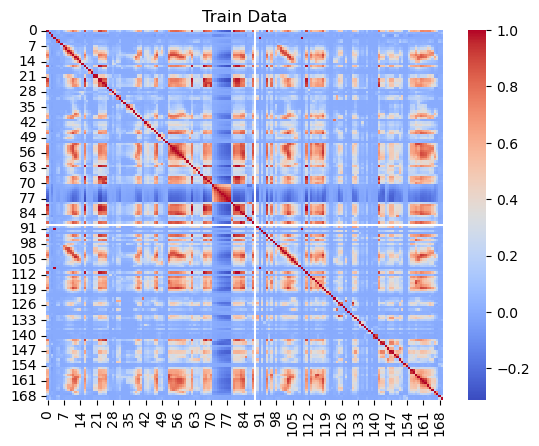

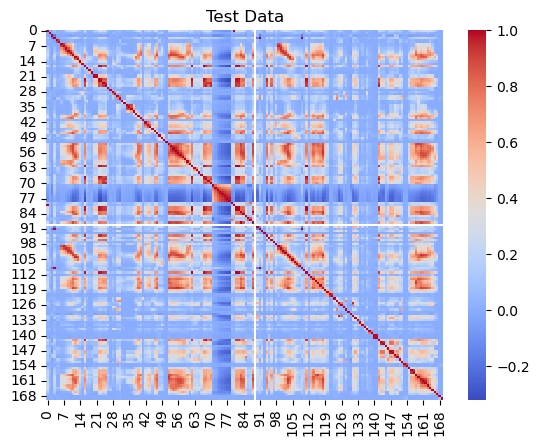

In [4]:
corr_train = impute_train.corr()
plt.figure()
sns.heatmap(corr_train, cmap='coolwarm')
plt.title('Train Data')
plt.show()

corr_test = impute_test.corr()
plt.figure()
sns.heatmap(corr_test, cmap='coolwarm')
plt.title('Test Data')
plt.show()

#### (iv) Make scatter plots and box plots

Conclusions is difficult to be drawn from scatter plot about significance of these features. There are data that are far away from other data.


<Figure size 640x480 with 0 Axes>

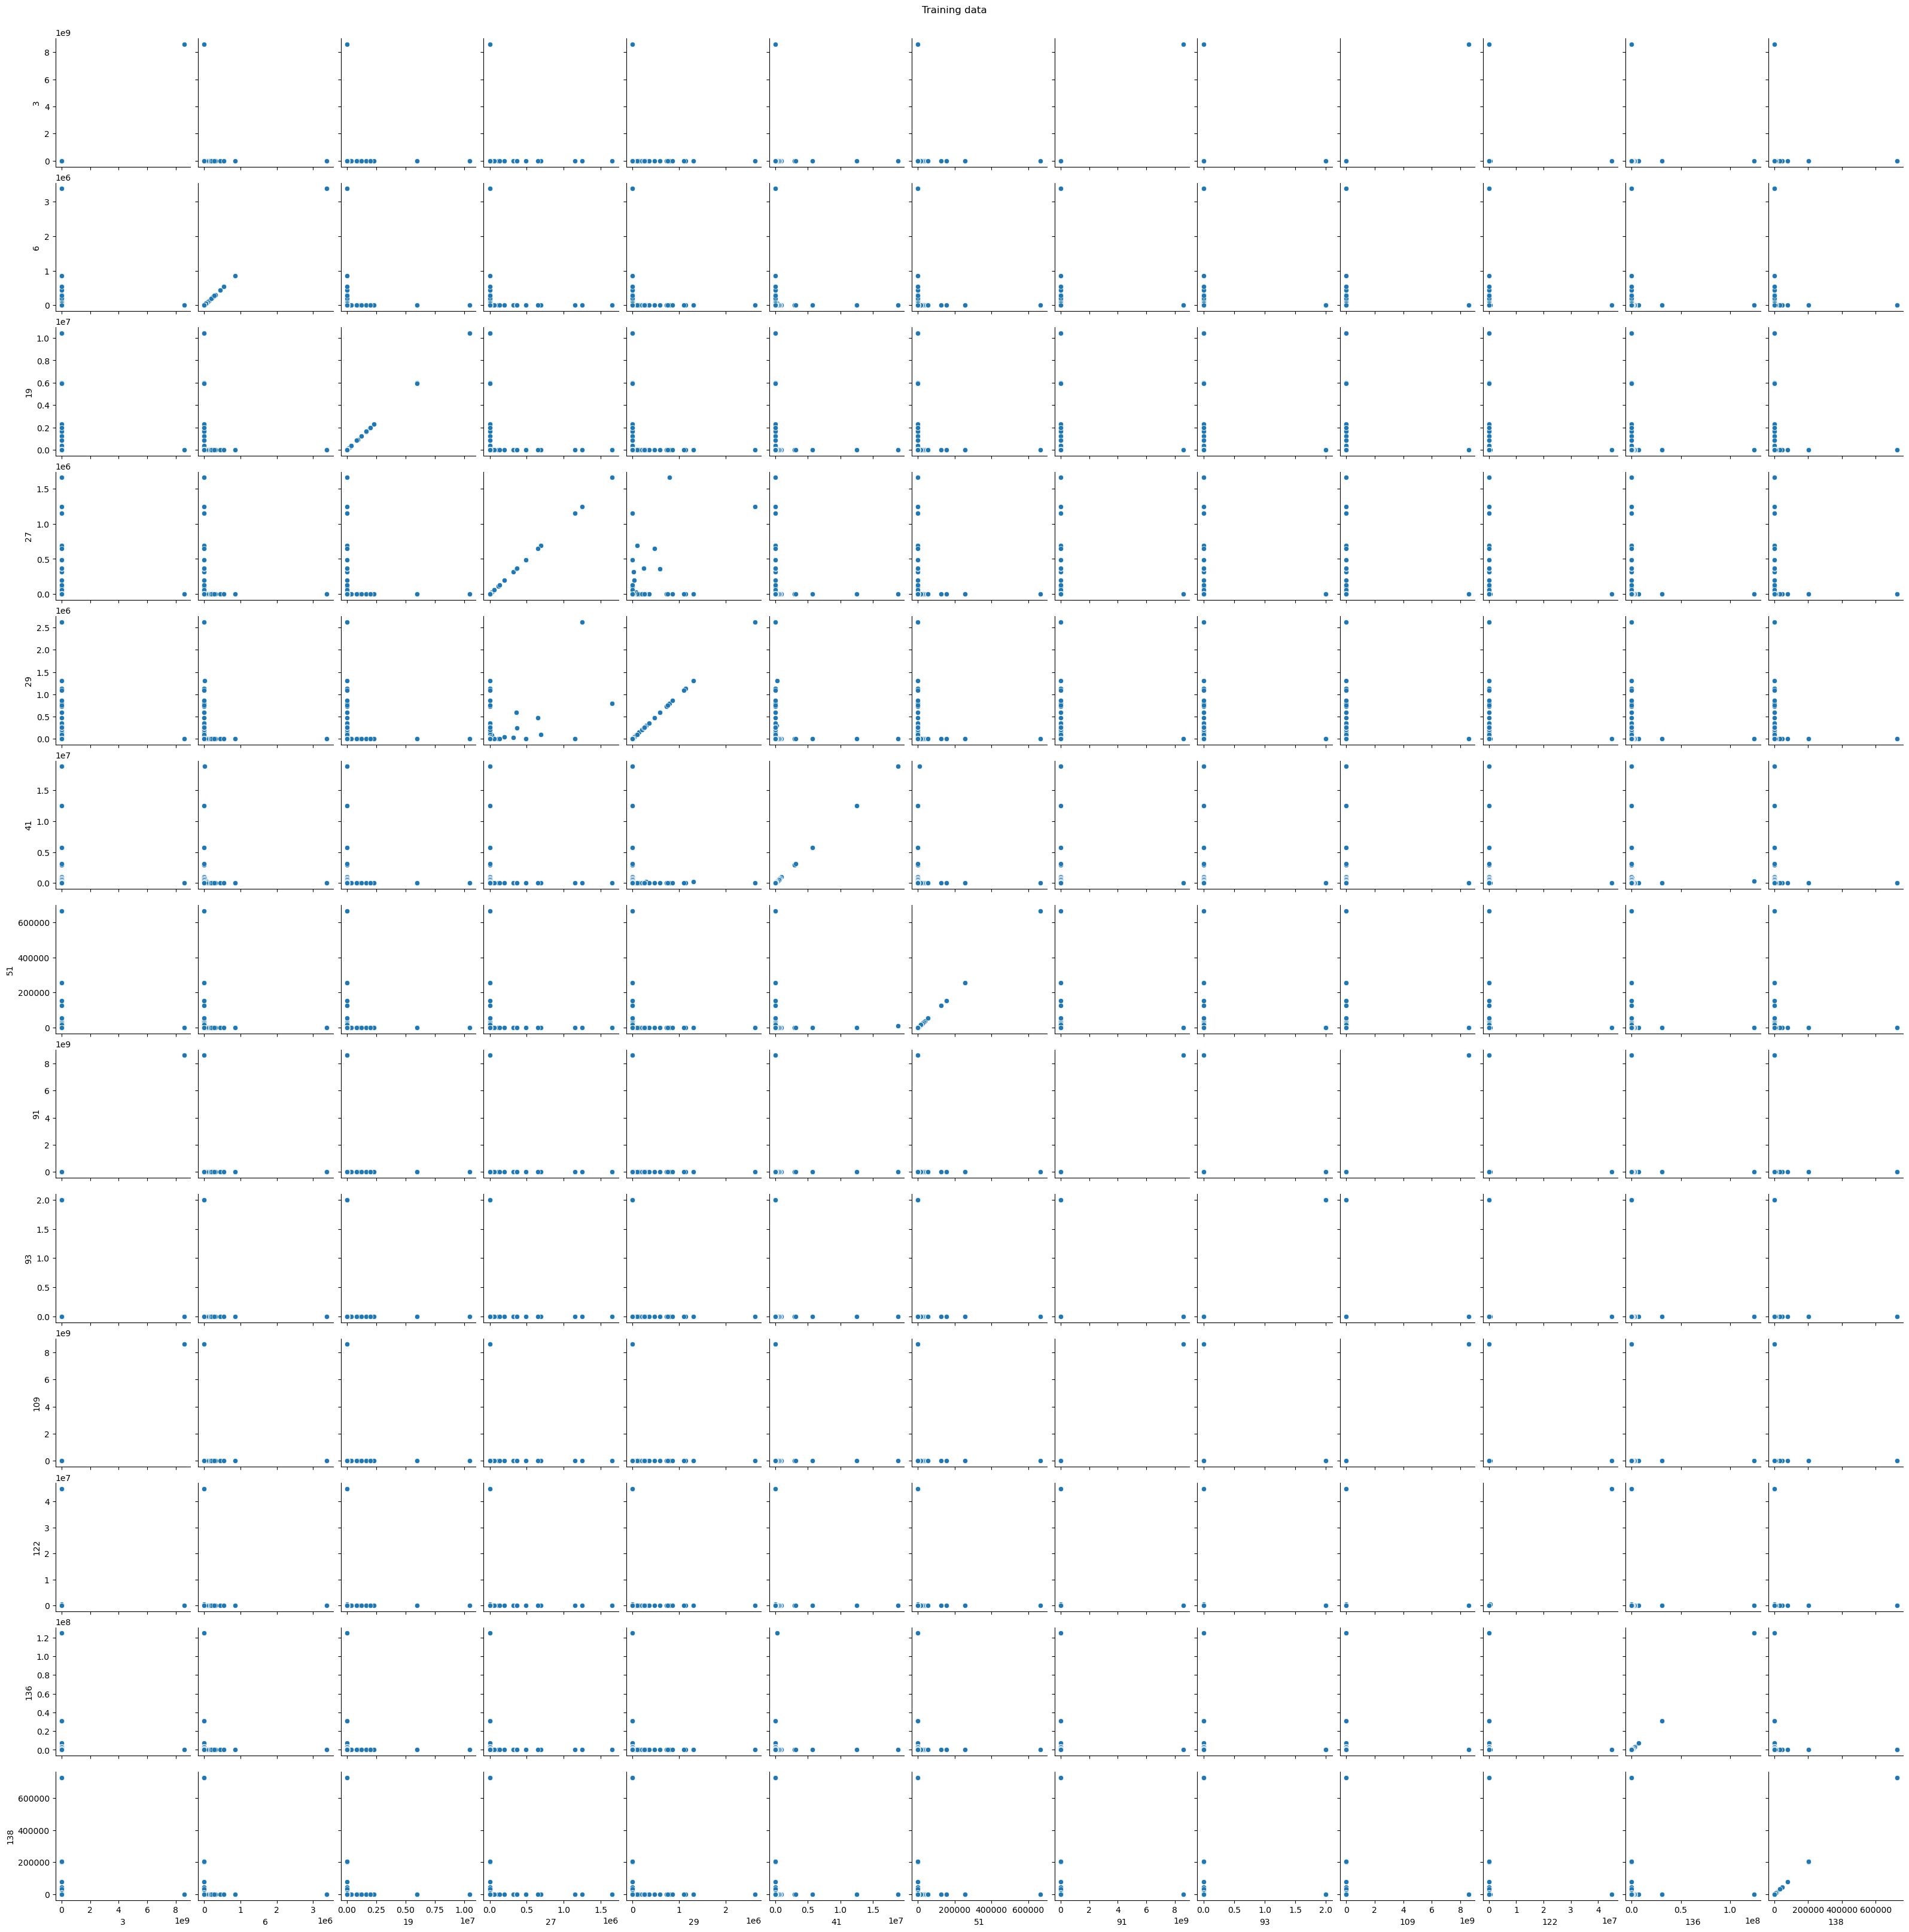

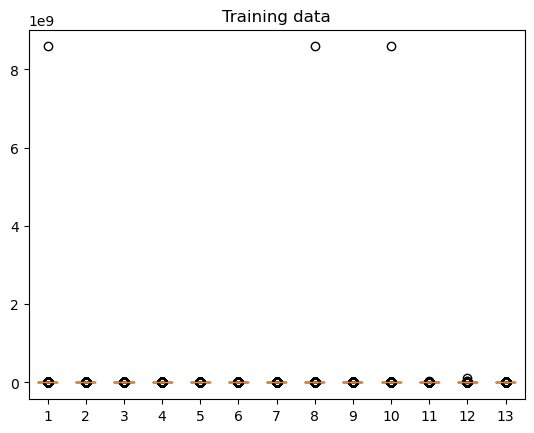

In [5]:
nofeature = np.floor(np.sqrt(170))
hightrain = cv_train.nlargest(nofeature.astype('int'))
hightest = cv_test.nlargest(nofeature.astype('int'))

print(f'Conclusions is difficult to be drawn from scatter plot about significance of these features. There are data that are far away from other data.')

train_1biv = impute_train.iloc[:,np.sort(hightrain.index)]
plt.figure()
sns.pairplot(train_1biv, diag_kind=None)
plt.gcf().suptitle('Training data', y=1)
plt.show()
plt.figure()
plt.boxplot(train_1biv)
plt.title('Training data')
plt.show()

<Figure size 640x480 with 0 Axes>

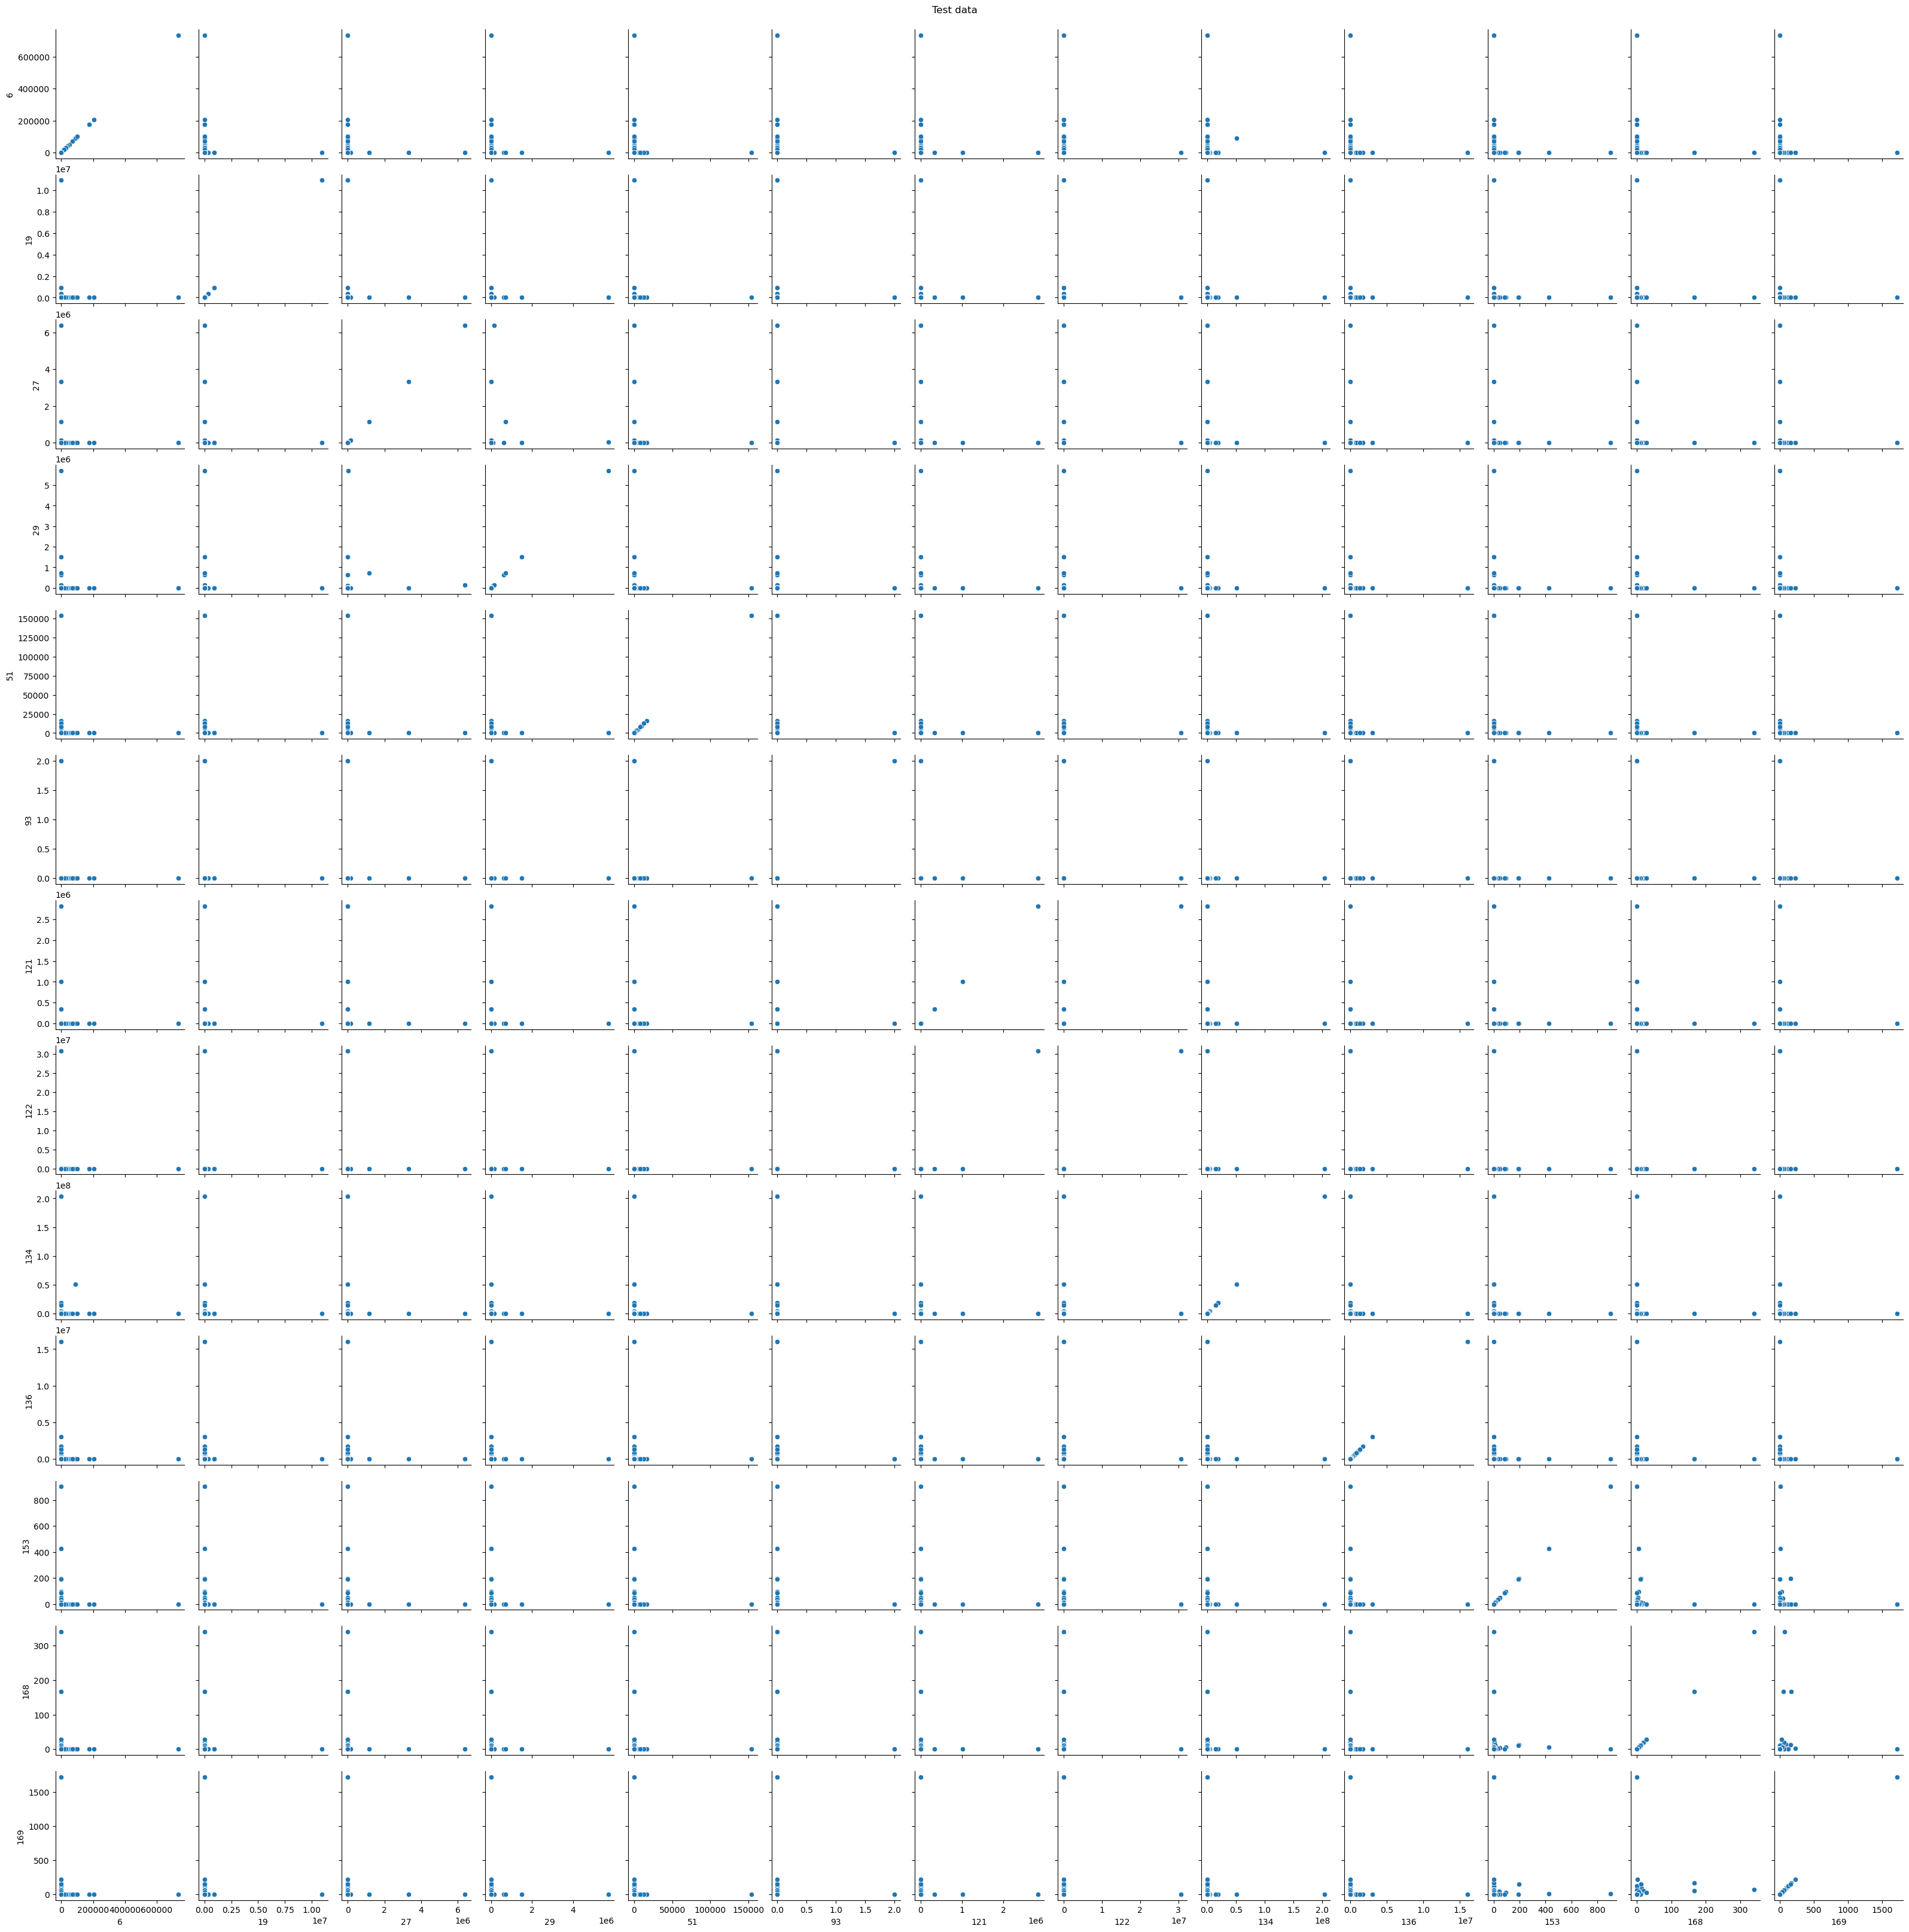

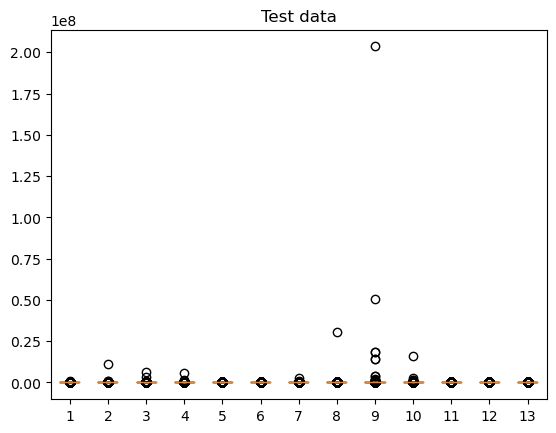

In [6]:
#Test data
test_1biv = impute_test.iloc[:,np.sort(hightest.index)]
plt.figure()
sns.pairplot(test_1biv, diag_kind=None)
plt.gcf().suptitle('Test data', y=1)
plt.show()
plt.figure()
plt.boxplot(test_1biv)
plt.title('Test data')
plt.show()

#### (v) Is this data set imbalanced?

In [7]:
count_train_pos = df_trainy.value_counts()[1]
prob_train_pos = count_train_pos/len(df_trainy)
count_train_neg = df_trainy.value_counts()[0]
prob_train_neg = count_train_neg/len(df_trainy)

count_test_pos = df_testy.value_counts()[1]
prob_test_pos = count_test_pos/len(df_testy)
count_test_neg = df_testy.value_counts()[0]
prob_test_neg = count_test_neg/len(df_testy)

print(f'The data set is severly imbalanced because there is less than 5% of positive class:', prob_train_pos, prob_test_pos)

The data set is severly imbalanced because there is less than 5% of positive class: 0.016666666666666666 0.0234375


### (c) Train a random forest

Training confusion matrix
[[59000     0]
 [    0  1000]]
Test confusion matrix
[[15606    19]
 [  108   267]]


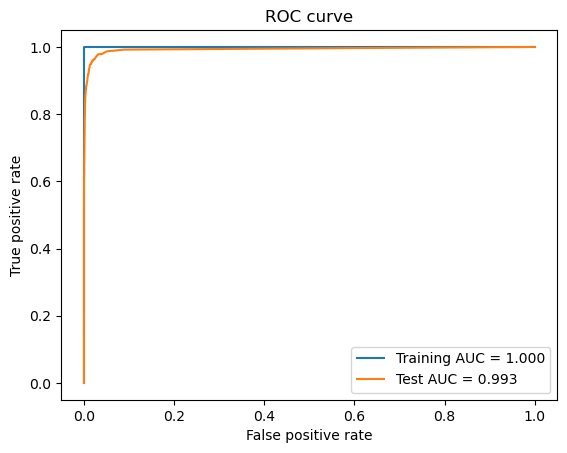

Training Misclassification Rate: 0.000
Test Misclassification Rate: 0.008
Out of Bag Error Estimate: 0.006


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy import interp
from sklearn.utils import resample

rfc_c = RandomForestClassifier(n_estimators=100, random_state=0, bootstrap=True, oob_score=True)
rfc_c.fit(impute_train, df_trainy)

ctrainy_pred = rfc_c.predict(impute_train)
ctrain_cm = confusion_matrix(df_trainy, ctrainy_pred)
print(f'Training confusion matrix')
print(ctrain_cm)

ctesty_pred = rfc_c.predict(impute_test)
ctest_cm = confusion_matrix(df_testy, ctesty_pred)
print(f'Test confusion matrix')
print(ctest_cm)

ctrain_proba = rfc_c.predict_proba(impute_train)[:,1]
ctrain_fpr, ctrain_tpr, c_ = roc_curve(df_trainy, ctrain_proba)
ctrain_auc = roc_auc_score(df_trainy, ctrain_proba)

ctest_proba = rfc_c.predict_proba(impute_test)[:,1]
ctest_fpr, ctest_tpr, c_ = roc_curve(df_testy, ctest_proba)
ctest_auc = roc_auc_score(df_testy, ctest_proba)

plt.figure()
plt.plot(ctrain_fpr, ctrain_tpr, label='Training AUC = {:.3f}'.format(ctrain_auc))
plt.plot(ctest_fpr, ctest_tpr, label='Test AUC = {:.3f}'.format(ctest_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ctrain_misclass = 1 - rfc_c.score(impute_train, df_trainy)
print('Training Misclassification Rate: {:.3f}'.format(ctrain_misclass))

ctest_misclass = 1 - rfc_c.score(impute_test, df_testy)
print('Test Misclassification Rate: {:.3f}'.format(ctest_misclass))

coob_error = 1 - rfc_c.oob_score_
print('Out of Bag Error Estimate: {:.3f}'.format(coob_error))

### (d) Research class imbalance in random forest

Training confusion matrix
[[59000     0]
 [    0  1000]]
Test confusion matrix
[[15614    11]
 [  166   209]]


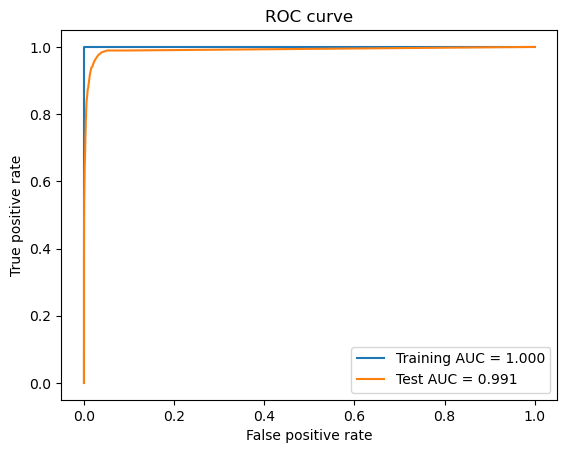

Training Misclassification Rate: 0.000
Test Misclassification Rate: 0.008
Out of Bag Error Estimate: 0.006
When comparing results with c, we see that confusion matrix and ROC curve were adjusted for the rare class, the out of the bag error did not change.


In [9]:
rfc_d = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced', bootstrap=True, oob_score=True)
rfc_d.fit(impute_train, df_trainy)

dtrainy_pred = rfc_d.predict(impute_train)
dtrain_cm = confusion_matrix(df_trainy, dtrainy_pred)
print(f'Training confusion matrix')
print(dtrain_cm)

dtesty_pred = rfc_d.predict(impute_test)
dtest_cm = confusion_matrix(df_testy, dtesty_pred)
print(f'Test confusion matrix')
print(dtest_cm)

dtrain_proba = rfc_d.predict_proba(impute_train)[:,1]
dtrain_fpr, dtrain_tpr, d_ = roc_curve(df_trainy, dtrain_proba)
dtrain_auc = roc_auc_score(df_trainy, dtrain_proba)

dtest_proba = rfc_d.predict_proba(impute_test)[:,1]
dtest_fpr, dtest_tpr, d_ = roc_curve(df_testy, dtest_proba)
dtest_auc = roc_auc_score(df_testy, dtest_proba)

plt.figure()
plt.plot(dtrain_fpr, dtrain_tpr, label='Training AUC = {:.3f}'.format(dtrain_auc))
plt.plot(dtest_fpr, dtest_tpr, label='Test AUC = {:.3f}'.format(dtest_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

dtrain_misclass = 1 - rfc_d.score(impute_train, df_trainy)
print('Training Misclassification Rate: {:.3f}'.format(ctrain_misclass))

dtest_misclass = 1 - rfc_d.score(impute_test, df_testy)
print('Test Misclassification Rate: {:.3f}'.format(ctest_misclass))

doob_error = 1 - rfc_d.oob_score_
print('Out of Bag Error Estimate: {:.3f}'.format(coob_error))

print(f'When comparing results with c, we see that confusion matrix and ROC curve were adjusted for the rare class, the out of the bag error did not change.')

### (e) XGBoost and Model Trees

Best alpha:  0.0001
Training confusion matrix
[[59000     0]
 [    1   999]]
Test confusion matrix
[[15609    16]
 [   79   296]]
Training error 1.666666666666483e-05
Test error 0.00593750000000004


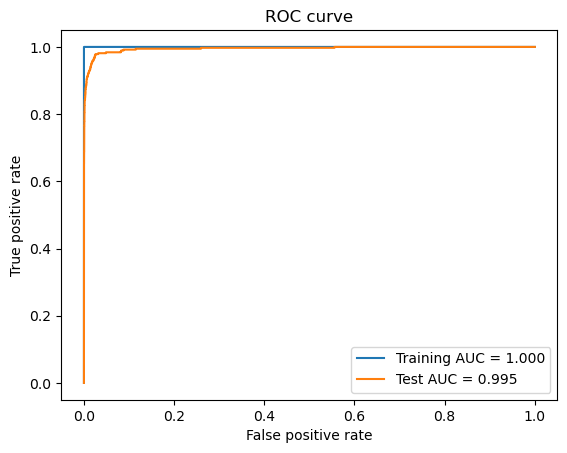

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=alphas, cv=5, scoring='accuracy')
grid_search.fit(impute_train, df_trainy)
print("Best alpha: ", grid_search.best_params_['alpha'])

xgb_best = xgb.XGBClassifier(alpha=grid_search.best_params_['alpha'])
xgb_best.fit(impute_train, df_trainy)

trainy_pred = xgb_best.predict(impute_train)
trainy_cm = confusion_matrix(df_trainy, trainy_pred)
print(f'Training confusion matrix')
print(trainy_cm)

testy_pred = xgb_best.predict(impute_test)
testy_cm = confusion_matrix(df_testy, testy_pred)
print(f'Test confusion matrix')
print(testy_cm)

train_err = 1 - accuracy_score(df_trainy, trainy_pred)
print(f'Training error', train_err)

test_err = 1 - accuracy_score(df_testy, testy_pred)
print(f'Test error', test_err)

train_proba = xgb_best.predict_proba(impute_train)[:,1]
train_fpr, train_tpr, _ = roc_curve(df_trainy, train_proba)
train_auc = roc_auc_score(df_trainy, train_proba)

test_proba = xgb_best.predict_proba(impute_test)[:,1]
test_fpr, test_tpr, _ = roc_curve(df_testy, test_proba)
test_auc = roc_auc_score(df_testy, test_proba)

plt.figure()
plt.plot(train_fpr, train_tpr, label='Training AUC = {:.3f}'.format(train_auc))
plt.plot(test_fpr, test_tpr, label='Test AUC = {:.3f}'.format(test_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### (f) Use SMOTE to pre-process your data

Best alpha:  0.01
Training confusion matrix
[[59000     0]
 [    1 58999]]
Test confusion matrix
[[15581    44]
 [   68   307]]
Training error 8.47457627117798e-06
Test error 0.007000000000000006


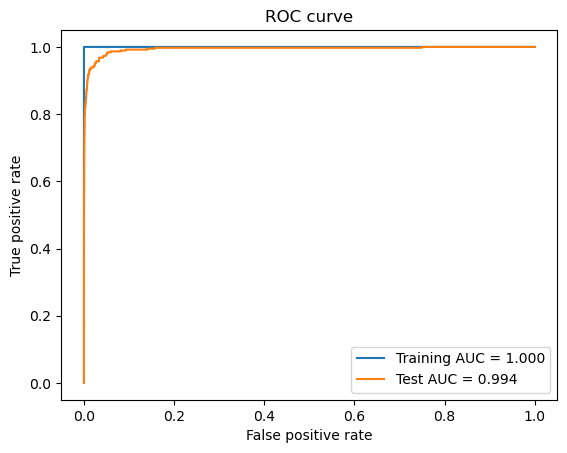

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
smote_trainx, smote_trainy = smote.fit_resample(impute_train, df_trainy)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(smote_trainx, smote_trainy)

alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=alphas, cv=5, scoring='accuracy')
grid_search.fit(smote_trainx, smote_trainy)
print("Best alpha: ", grid_search.best_params_['alpha'])

xgb_best = xgb.XGBClassifier(alpha=grid_search.best_params_['alpha'])
xgb_best.fit(smote_trainx, smote_trainy)

trainy_pred = xgb_best.predict(smote_trainx)
trainy_cm = confusion_matrix(smote_trainy, trainy_pred)
print(f'Training confusion matrix')
print(trainy_cm)

testy_pred = xgb_best.predict(impute_test)
testy_cm = confusion_matrix(df_testy, testy_pred)
print(f'Test confusion matrix')
print(testy_cm)

train_err = 1 - accuracy_score(smote_trainy, trainy_pred)
print(f'Training error', train_err)

test_err = 1 - accuracy_score(df_testy, testy_pred)
print(f'Test error', test_err)

train_proba = xgb_best.predict_proba(smote_trainx)[:,1]
train_fpr, train_tpr, _ = roc_curve(smote_trainy, train_proba)
train_auc = roc_auc_score(smote_trainy, train_proba)

test_proba = xgb_best.predict_proba(impute_test)[:,1]
test_fpr, test_tpr, _ = roc_curve(df_testy, test_proba)
test_auc = roc_auc_score(df_testy, test_proba)

plt.figure()
plt.plot(train_fpr, train_tpr, label='Training AUC = {:.3f}'.format(train_auc))
plt.plot(test_fpr, test_tpr, label='Test AUC = {:.3f}'.format(test_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(f'When comparing uncompensated with SMOTE, the values and errors did not change drastically.')

## 2. ISLR 6.6.3

a) iv; Training RSS will steadily decrease because the s will get larger to capture smaller error.
<br> 
b) ii; Test RSS will decrease initially and then eventually start increasing a a U shape because the s will get larger and error will get smaller, then as s get much larger, it will overfit so error will be larger again.
<br> 
c) iii ; Varian will steadily increase because when s get larger, there are more possible model so more variance.
<br> 
d) iv; Bias will steadily decrease because variance is increased due to bias variance trade off.
<br> 
e) v; Irreducible error remain constant because this capture is not something we can control.

## 3. ISLR 6.6.5

a)
<br>
$\sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} \beta_{j}^{2}$
<br>
<br>
$x_11 = x_12,\; x_21 = x_22,\; \hat{\beta_{0}} = 0$
<br>
<br>
$[y_1 - x_1 (\beta_1 + \beta_2)]^2 + [y_2 - x_2 (\beta_1 + \beta_2)]^2 + \lambda (\beta_{1}^{2} + \beta_{2}^{2})$
<br>
b)
<br>
Ridge coefficient estimate satisify $\hat{\beta_1} = \hat{\beta_2}$ because the betas are symmetrical and similar
<br>
$\beta_1 = \frac{y_1 x_1 + y_2 x_2 - \beta_2 x_1^2 - \beta_2 x_2^2}{x_1^2 + x_2^2 + \lambda}$
<br>
$\beta_2 = \frac{y_1 x_1 + y_2 x_2 - \beta_1 x_1^2 - \beta_1 x_2^2}{x_1^2 + x_2^2 + \lambda}$
<br>
c)
<br>
$[y_1 - x_1 (\beta_1 + \beta_2)]^2 + [y_2 - x_2 (\beta_1 + \beta_2)]^2 + \lambda (|\beta_{1}| + |\beta_{2}|)$
<br>
d)
<br>
Lasso will have many possible solutions to beta because after using the conditions, our equation simplify to 
$2(y_1 - (\beta_1 + \beta_2)x_11)^2$ so the minmum zero is a line that is $\beta_1 + \beta_2 = \frac{y_1}{x_{11}}$ so in the lasso s, where it is square, the entire line would touch the square giving multiple solutions to betas.

## 4. ISLR 8.4.5

Under majority vote, the final classification would be red because majority of them fell under red.
<br>
Classifying based on average probability, the final classification will be green because average probability is 0.45 so green.

## 5. ISLR 9.7.3

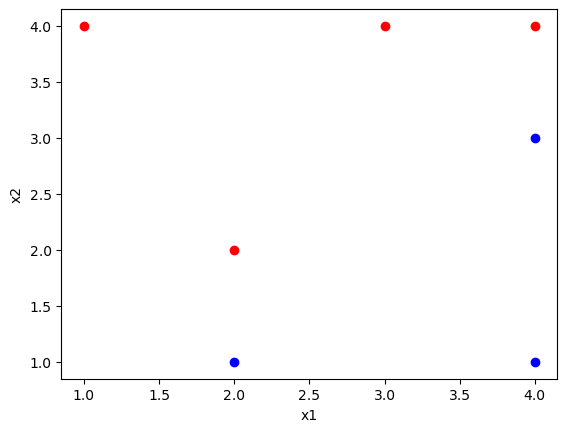

In [12]:
#a
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
plt.figure()
plt.scatter(x1[:4], x2[:4], color='red')
plt.scatter(x1[4:], x2[4:], color='blue')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

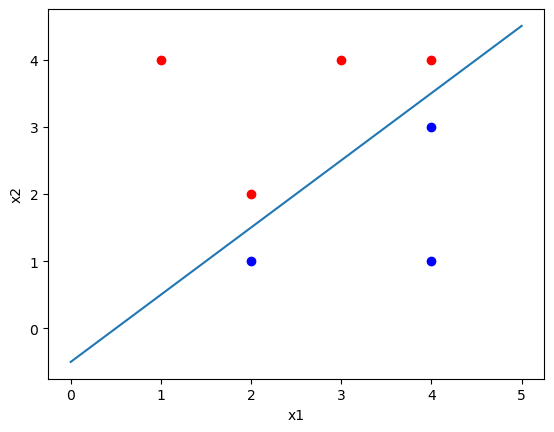

In [13]:
#b
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
plt.scatter(x1[:4], x2[:4], color='red')
plt.scatter(x1[4:], x2[4:], color='blue')
x = np.linspace(0, 5, 100)
y = x - 0.5
plt.plot(x, y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

c) 
<br>
$\beta_0 + \beta_1 x_1 + \beta_2 x_2 > 0$ classify to red
<br>
$\beta_0 + \beta_1 x_1 + \beta_2 x_2 < 0$ classify to blue
<br>
$\beta_0 = -0.5$
<br>
$\beta_1 = 1$
<br>
$\beta_2 = -1$

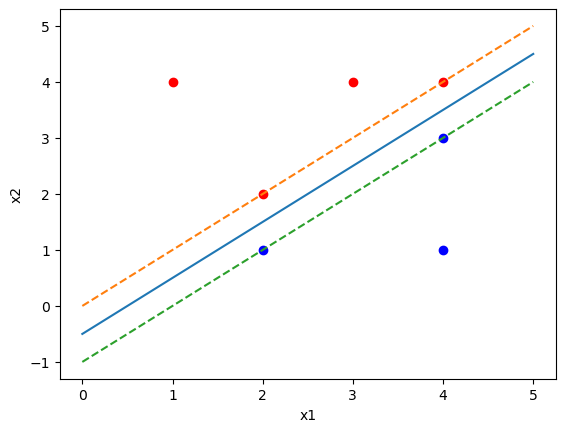

In [14]:
#d
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
plt.scatter(x1[:4], x2[:4], color='red')
plt.scatter(x1[4:], x2[4:], color='blue')
x = np.linspace(0, 5, 100)
y = x - 0.5
rline = x
bline = x - 1
plt.plot(x, y)
plt.plot(x, rline, '--')
plt.plot(x, bline, '--')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

e) The support vectors are observation 2, 3, 5, and 6
<br>
f) Slight movement of seventh observation would not affect maximal margin hyperplane because it is not the support vector and does not influence the margin or the hyperplane. Only if it moves insider the dash lines, the hyperplane would be affected.
<br>

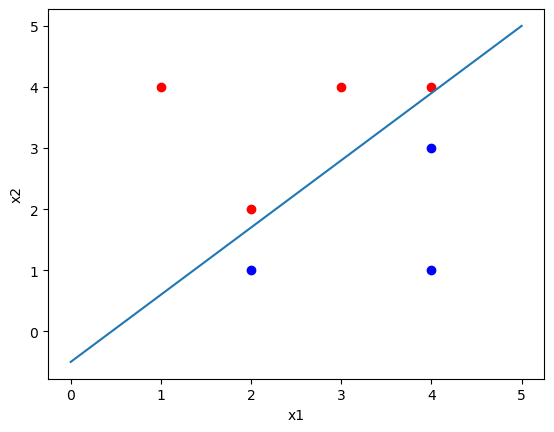

In [15]:
#g
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
plt.scatter(x1[:4], x2[:4], color='red')
plt.scatter(x1[4:], x2[4:], color='blue')
x = np.linspace(0, 5, 100)
g = 1.1*x - 0.5
plt.plot(x, g)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

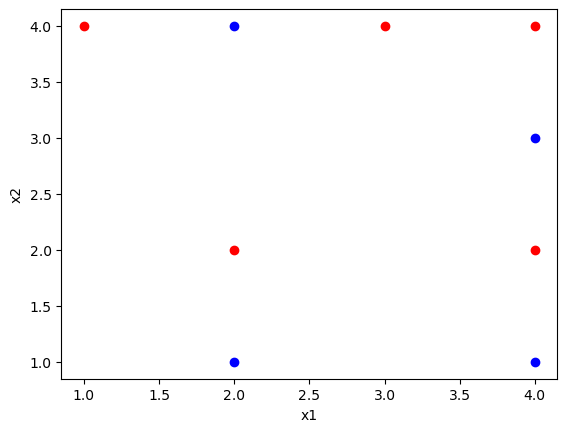

In [16]:
#h
x1 = [4, 3, 2, 4, 1, 2, 4, 4, 2]
x2 = [2, 4, 2, 4, 4, 1, 3, 1, 4]
plt.figure()
plt.scatter(x1[:5], x2[:5], color='red')
plt.scatter(x1[5:], x2[5:], color='blue')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()